In [1]:
import tools
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor



In [2]:
def _bipolar_reference(data_arg):
    (n_time_samples, n_channels) = data_arg.shape
    # separate contact names
    leads = []
    contacts = []
    for i in data_arg.columns:
        if i in ['C3', 'C4', 'ECG1', 'ECG2']:
            n_channels = n_channels - 1
            continue

        M = re.match(r"(\D+)(\d+)", i)
        if M is None:
            n_channels = n_channels - 1
            continue
        leads.append(M.group(1).replace("EEG", "").strip())
        contacts.append(int(M.group(2)))

    leads_contacts = [f"{i}{j:02d}" for i, j in zip(leads, contacts)]
    col_names = []
    data_entries = []
    # find montage channel before
    for index in range(n_channels - 1):
        lead = leads[index]
        contact = contacts[index]

        next_lead_contact = f"{lead}{(contact + 1):02d}"

        try:
            next_index = leads_contacts.index(next_lead_contact)
        except ValueError:
            continue

        col_names.append(f"{leads_contacts[index]}-{leads_contacts[next_index]}")
        data_entries.append(data_arg.iloc[:, index] - data_arg.iloc[:, next_index])
    
    data_entries = np.array(data_entries).T
    bipolar_data = pd.DataFrame(data_entries, columns=col_names, index=data_arg.index)

    return bipolar_data


In [3]:
# username = 'pattnaik'
# pwd_bin_file = '/mnt/local/gdrive/public/USERS/pattnaik/pre-ictal-similarity/code/pat_ieeglogin.bin'

username = 'igvilla'
pwd_bin_file = '/gdrive/public/USERS/igvilla/igv_ieeglogin.bin'

###

# practice of a random new time:
# start_time_sec = 315961
# end_time_sec = 315961 + 60 

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

### 

# LB3_001_phaseII, seizure 1:
start_time_sec = 401844.64 - 60 # showing starting 1 minute before the seizure
end_time_sec = 401844.64 + 53.4099999999743

# LB3_001_phaseII, seizure 1:
iEEG_filename = 'LB3_004'
start_time_usec = start_time_sec * 1e6
end_time_usec = end_time_sec * 1e6




In [4]:
data, fs = tools.get_iEEG_data(username, pwd_bin_file, iEEG_filename, start_time_usec, end_time_usec, select_electrodes=np.arange(25))



In [5]:
start_time_usec, end_time_usec

(401784640000.0, 401898050000.0)

In [6]:
end_time_sec - start_time_sec

113.40999999997439

In [7]:
# extract dims
(n_samples, n_channels) = data.shape

# set time array
t_sec = np.linspace(start_time_sec, end_time_sec, n_samples)

# remove 60Hz noise
b, a = iirnotch(F0, Q, fs)
signal_filt = filtfilt(b, a, data, axis=0)

# bandpass between 1 and 120Hz
bandpass_b, bandpass_a = butter(3, [1, 120], btype='bandpass', fs=fs)
signal_filt = filtfilt(bandpass_b, bandpass_a, signal_filt, axis=0)

# format resulting data into pandas DataFrame
signal_filt = pd.DataFrame(signal_filt, columns=data.columns)
signal_filt.index = pd.to_timedelta(t_sec, unit="S")

signal_ref = _bipolar_reference(signal_filt)

In [8]:
np.size(signal_ref)

261297

In [9]:
signal_ref

,A01-A02,EKG01-EKG02,F03-F04,F07-F08,F08-F09,F09-F10,Fp01-Fp02,O01-O02,P03-P04
4 days 15:36:24.640000,0.386057,-23.122026,-4.148610,-2.169412,0.558222,1.564397,-18.034650,-4.976327,1.193096
4 days 15:36:24.643906379,-0.392177,-31.670976,-5.814925,-1.817845,6.043462,-3.856548,198.288657,2.210315,1.636749
4 days 15:36:24.647812758,-1.467363,-30.066575,-11.084827,-8.515844,-9.851074,12.481207,249.846426,-12.869157,0.344953
4 days 15:36:24.651719138,-1.209724,-51.442881,-10.877383,-3.860957,-21.627174,17.812441,60.287488,-18.217509,-2.749149
4 days 15:36:24.655625517,0.955781,-54.750433,-15.153200,-10.564440,-4.876276,7.751597,-17.461306,-10.382130,-4.139994
...,...,...,...,...,...,...,...,...,...
4 days 15:38:18.034374483,-4.286819,-15.671529,-22.980108,-90.242465,57.777555,4.349222,318.946544,-1299.681546,-40.117300
4 days 15:38:18.038280862,-4.769036,-45.016104,-14.057243,20.622845,-46.085414,17.650647,323.616422,-1077.586245,-10.421392
4 days 15:38:18.042187242,-4.539570,-35.543349,-8.120029,2.980104,-25.766561,22.185493,324.197232,-1172.575046,-0.614327
4 days 15:38:18.046093621,-3.901487,-16.920194,-14.729984,39.515129,-51.571695,12.138831,508.062928,-1429.987405,-3.660527


In [10]:
signal_ref.to_hdf(f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5", key='ieeg')

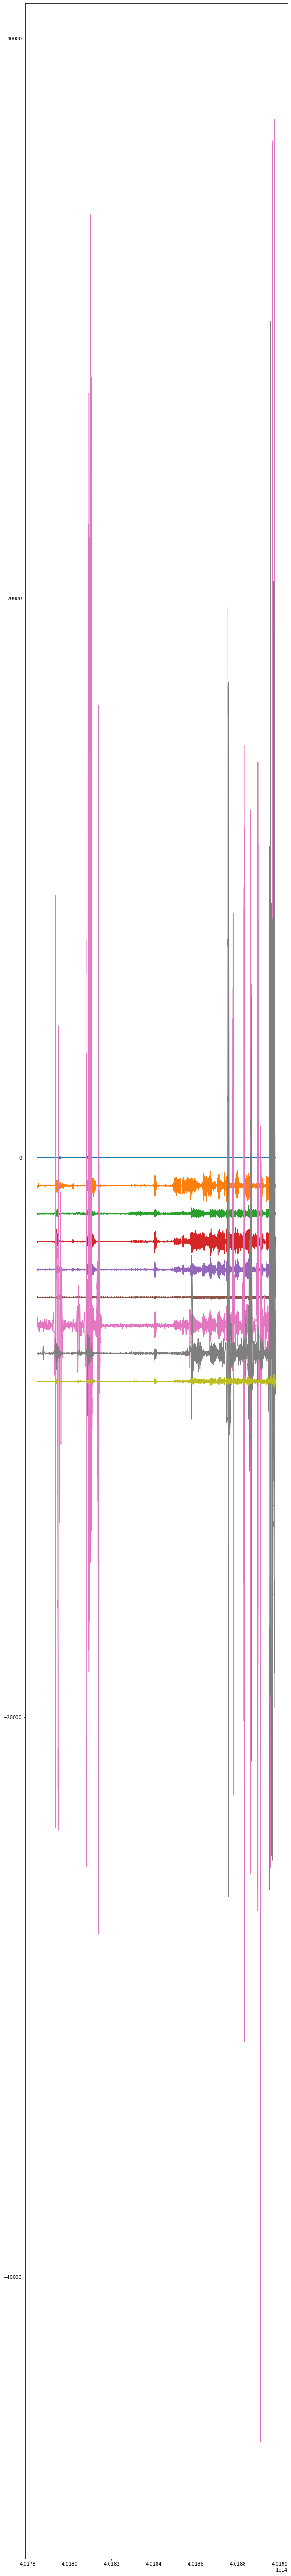

In [11]:
# changed from 34 to 9
plt.figure(figsize=(10, 100)); plt.plot(signal_ref.iloc[:, 0:9] + np.arange(9)*-1000)